In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import math
import os
import bghelperfunctions as bg
from bghelperfunctions import TimeBandTargets
import scipy.ndimage.measurements as im_meas
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
plt.rcParams['figure.figsize'] = [3.937, 3.937]

## Data import and munging

In [2]:
# # generate dummy data
# dts = np.array([(datetime.datetime.now()-datetime.timedelta(minutes=30*x)) for x in range(4*30*24*2)]);
# bg_max = 15 * 18.0;
# bg_min = 2.5 * 18.0;
# calibrated_readings_flat = np.array([bg_max/2 + bg_min/2 for dt in dts]);
# calibrated_readings_daily_hypo = abs(np.array([2.5*18.0 if dt.hour==(datetime.datetime.now() - datetime.timedelta(hours=1)).hour 
#                                   else (bg_max/2 + bg_min/2) for dt in dts]) + np.random.normal(loc=0, scale=9.0, size=len(dts)))
# calibrated_readings_sine = abs(bg_min + (bg_max - bg_min) * abs(np.sin(np.array([2* math.pi *dt.hour/48 for dt in dts]))) + np.random.normal(loc=0, scale=9.0, size=len(dts)));

# df = pd.DataFrame();
# df['datetime'] = dts; 
# df['datetime'] = pd.to_datetime(df['datetime']).dt.round('1s')
# df['datetime'] = df['datetime']
# df['calibrated_reading'] = calibrated_readings_sine;

# df['time'] = df['datetime'].dt.time
# df['date'] = df['datetime'].dt.date
# df['BG, mmoll-1'] = (df['calibrated_reading']/18.0).round(1)
# df.set_index(df['datetime'], inplace=True)

# df.head()

In [3]:
# import real data
df = pd.read_csv('C:\\Users\\Doug\\Dropbox\\Apps\\Glimp\\GlicemiaMisurazioni.csv.gz', 
                compression='gzip', 
                header=None, 
                sep=';',
                encoding='utf-16-le', 
                usecols=[1,4,5], 
                names=['datetime', 'uncalibrated_reading', 'calibrated_reading'])

df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H.%M.%S').dt.round('1s');
df.set_index(df['datetime'], inplace=True)
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['BG, mmoll-1'] = (df['calibrated_reading']/18.0).round(1)
df.tail()

,datetime,uncalibrated_reading,calibrated_reading,time,date,"BG, mmoll-1"
datetime,,,,,,
2018-10-02 16:26:30,2018-10-02 16:26:30,NaN,384.0,16:26:30,2018-10-02,21.3
2018-10-02 16:11:30,2018-10-02 16:11:30,NaN,374.0,16:11:30,2018-10-02,20.8
2018-10-02 15:56:30,2018-10-02 15:56:30,NaN,362.0,15:56:30,2018-10-02,20.1
2018-10-02 15:41:30,2018-10-02 15:41:30,NaN,350.0,15:41:30,2018-10-02,19.4
2018-10-02 15:26:30,2018-10-02 15:26:30,NaN,337.0,15:26:30,2018-10-02,18.7


## Today's BGs

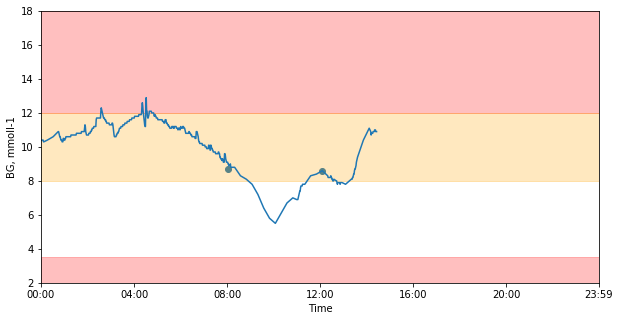

In [4]:
fig, ax = plt.subplots(1,1,figsize=[10,5])
bg.plot_daily_BG(df, datetime.date.today(), ax)
    
bg.add_daily_scatter(df, datetime.date.today(), ax)
plt.show()

## This week's BGs

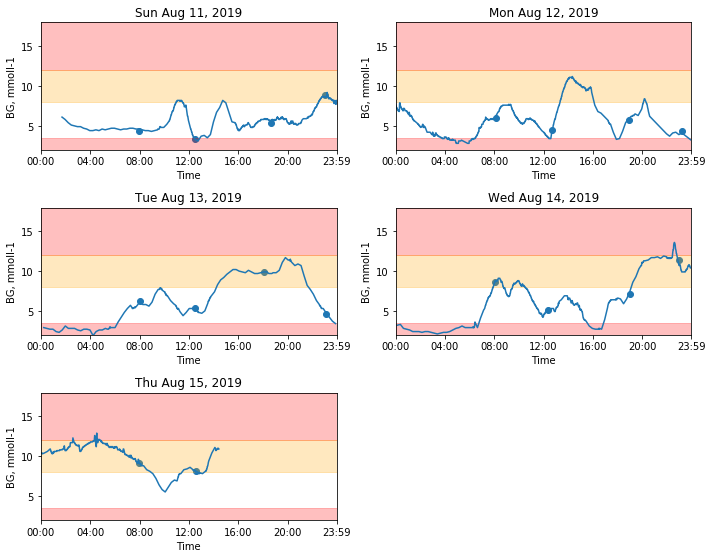

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]
sunday = bg.lastWday(datetime.date.today() - datetime.timedelta(days=0), 6)
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig2, ax2 = plt.subplots(4,2, figsize=[10,10])
for didx in range(7):
    date = sunday + datetime.timedelta(days=didx)
    axidx = (int(math.floor(didx/2)), didx % 2)
    if date <= datetime.date.today():
        bg.plot_daily_BG(df, date, ax2[axidx])
        bg.add_daily_scatter(df, date, ax2[axidx])
        ax2[axidx].set_title(date.strftime("%a %b %d, %Y"))
    else:
        ax2[axidx].set_visible(False)
ax2[-1,1].set_visible(False)
plt.tight_layout()

## Save weekly plots

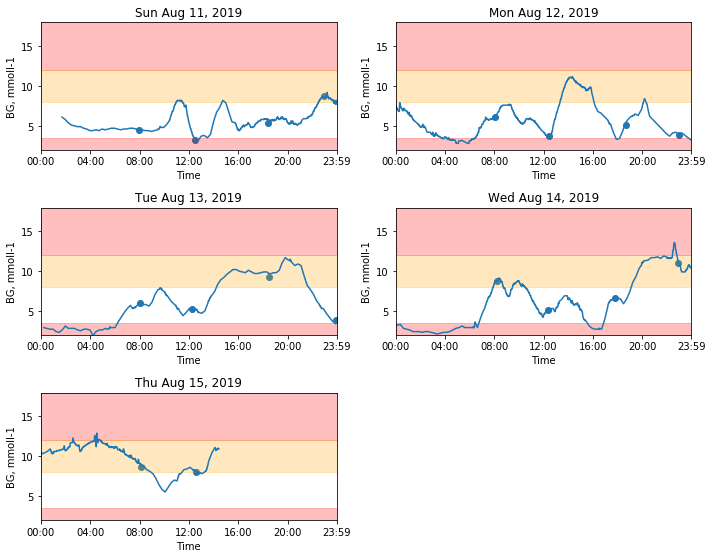

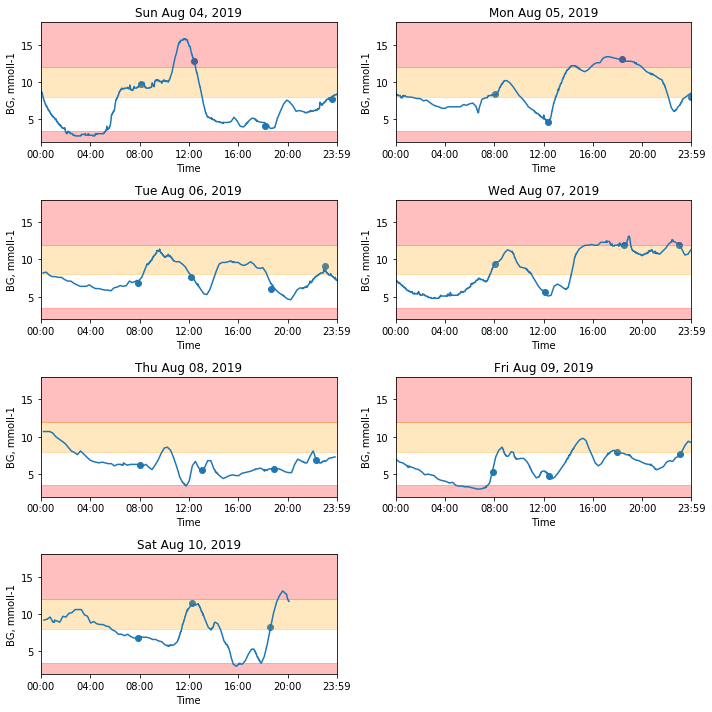

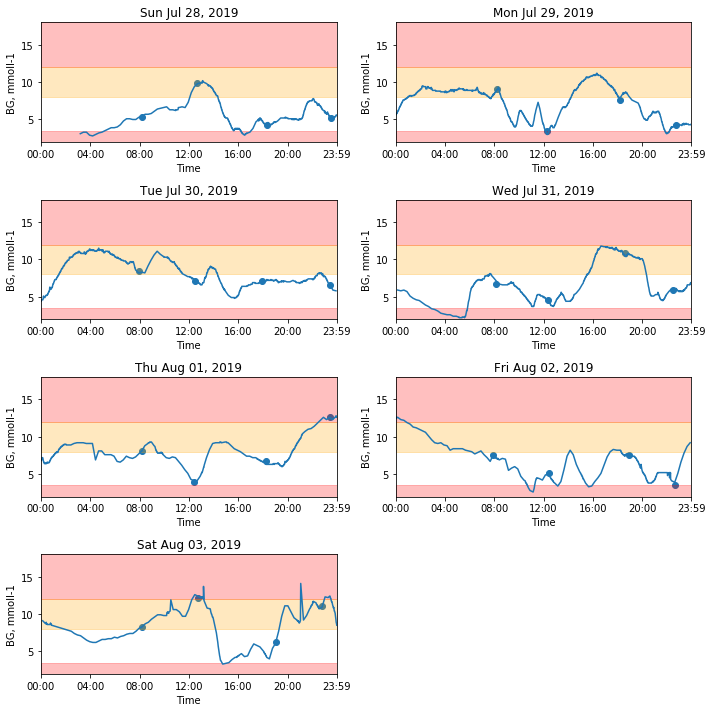

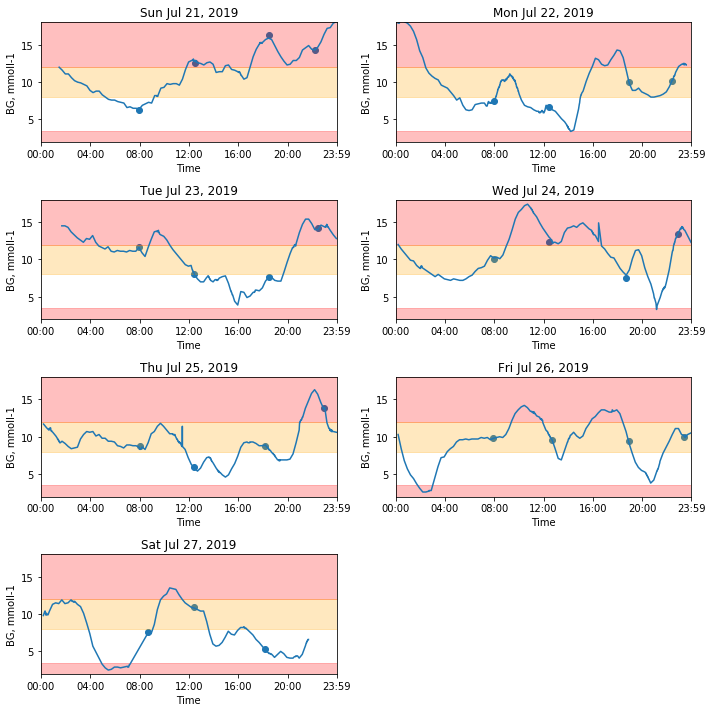

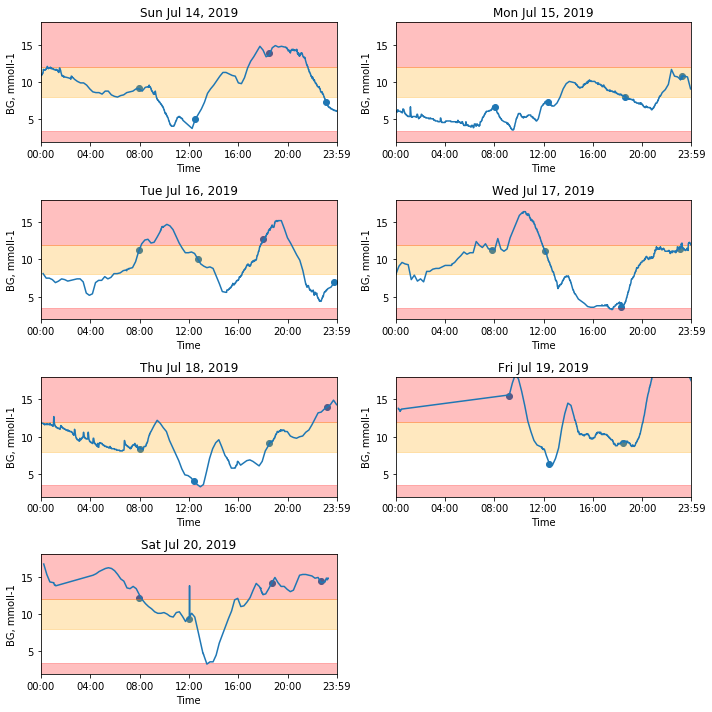

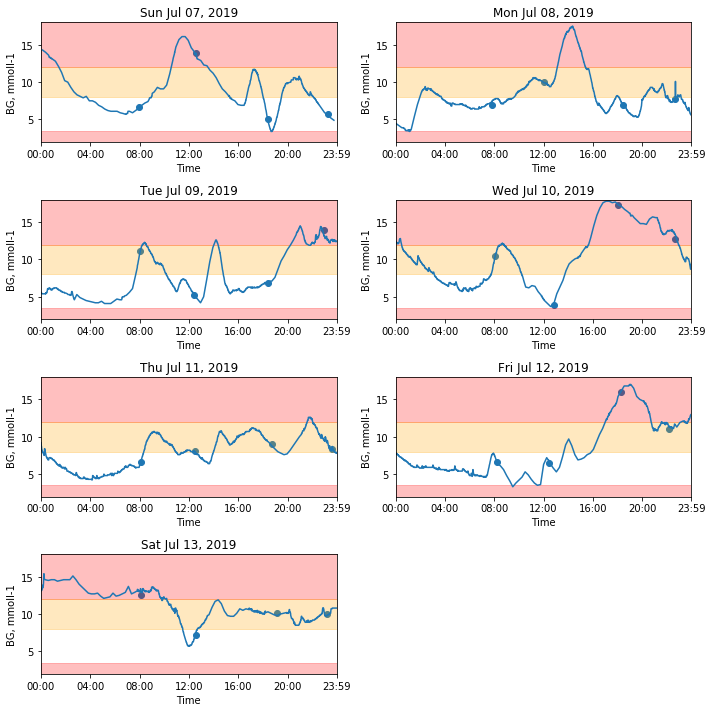

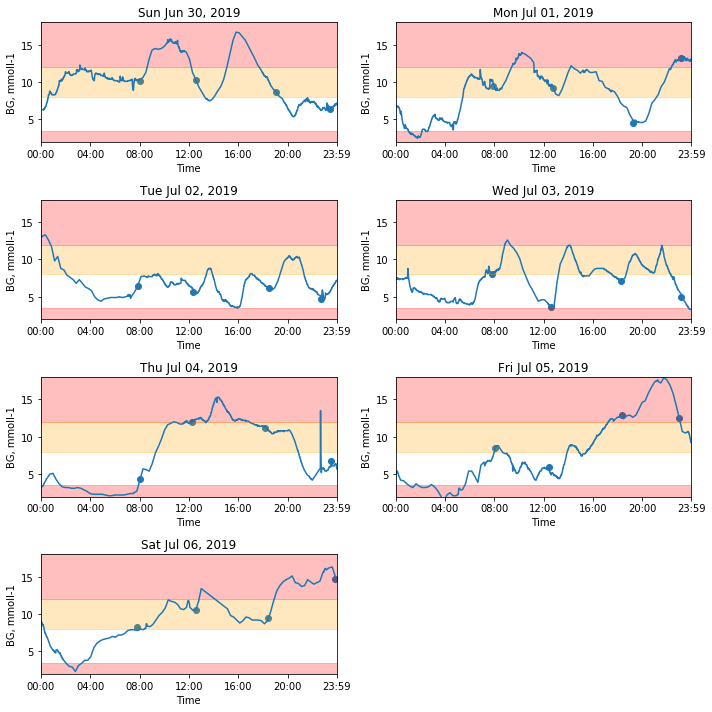

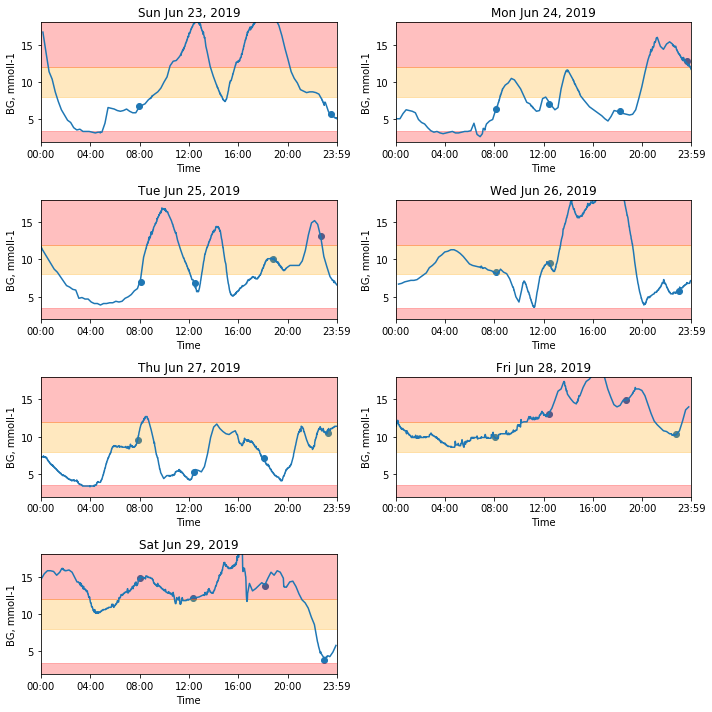

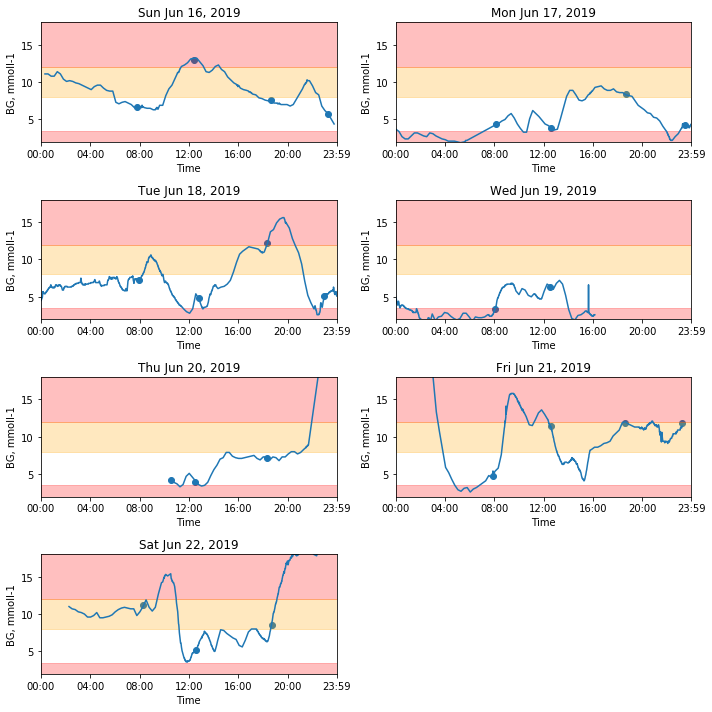

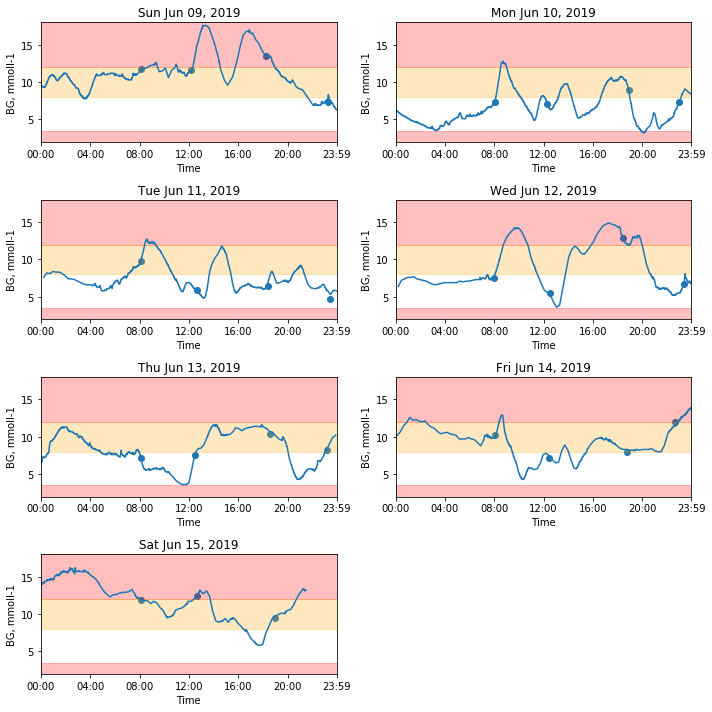

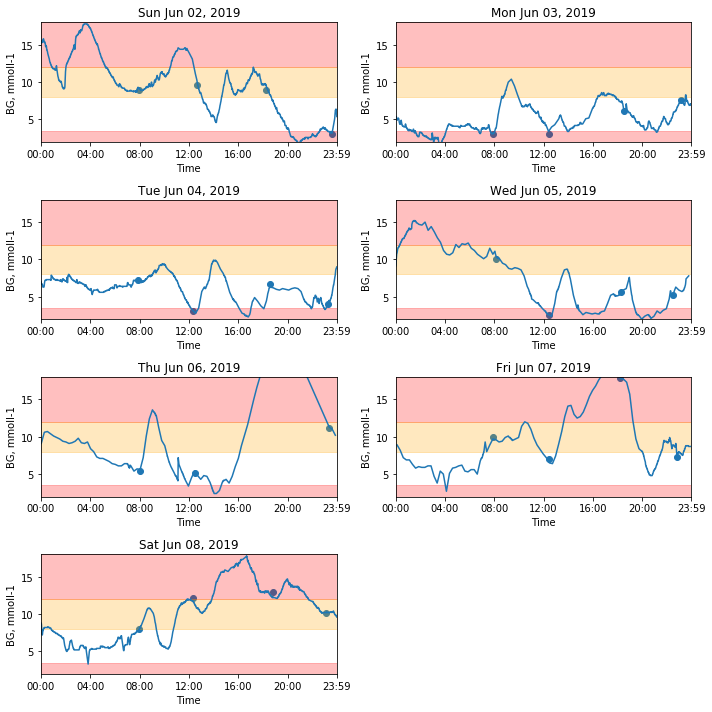

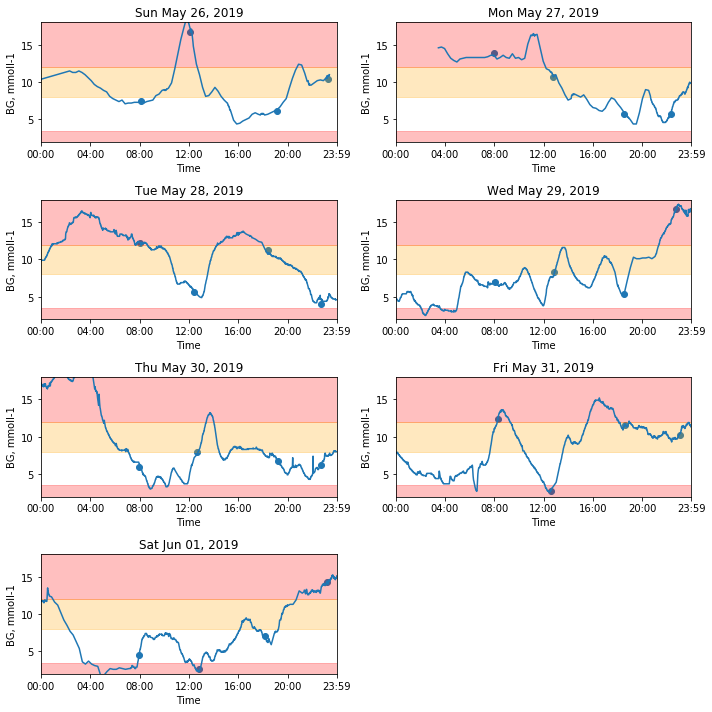

In [6]:
outpath = "C:\\Users\\Doug\\Desktop\\BG data\\Visit 29-07-2019"
for weekidx in range(12):
    sunday = bg.lastWday(datetime.date.today() - datetime.timedelta(days=weekidx*7), 6)

    fig2, ax2 = plt.subplots(4,2, figsize=[10,10])
    for didx in range(7):
        date = sunday + datetime.timedelta(days=didx)
        axidx = (int(math.floor(didx/2)), didx % 2)
        if date <= datetime.date.today():
            bg.plot_daily_BG(df, date, ax2[axidx])
            bg.add_daily_scatter(df, date, ax2[axidx])
            ax2[axidx].set_title(date.strftime("%a %b %d, %Y"))
        else:
            ax2[axidx].set_visible(False)
    ax2[-1,1].set_visible(False)
    plt.tight_layout()
    fname = sunday.strftime("Week starting %Y-%m-%d.png")
    plt.savefig(os.path.join(outpath, fname))

## Long-term pattern spotting

Display a median/interquartile range line plot to show how blood sugar typically varies with time of day over a set period. Also display the percentage of time spent within set limits at different distinct times of day, and a colormap showing the occurance of hypoglycaemic episodes over a long period. 

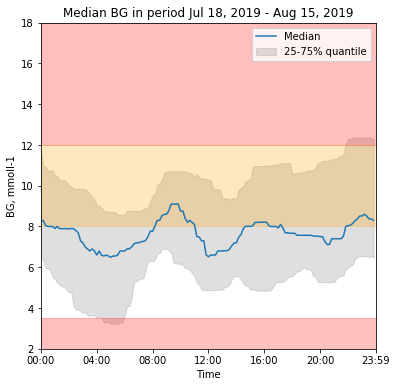

In [10]:
# plt.rcParams['figure.figsize'] = [2.95, 2.95] # 7.5 cm high
plt.rcParams['figure.figsize'] = [6, 6]
enddate = datetime.date.today()
startdate = datetime.date.today() - datetime.timedelta(days=28*1)
# %prun ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600)
ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600)

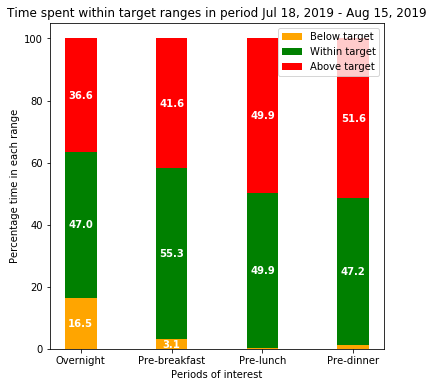

In [11]:
time_band_targetses = [];
time_band_targetses.append(TimeBandTargets());
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-breakfast',
                                           time_start_end=(7,8),
                                           target_bg=(4.0, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-lunch',
                                           time_start_end=(10.5,12),
                                           target_bg=(3.5, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-dinner',
                                           time_start_end=(16,18),
                                           target_bg=(3.5, 8.0)))

output = bg.percentageTimeInTarget(df, startdate, enddate, time_band_targetses);

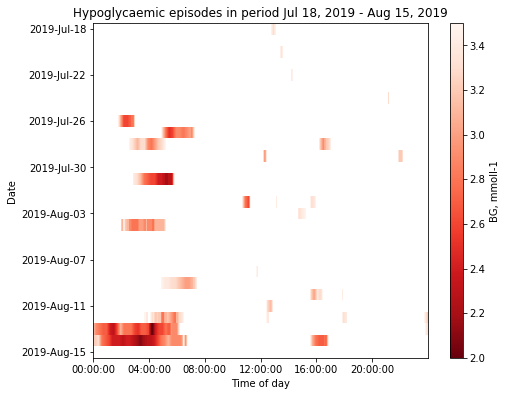

In [12]:
# %prun bg.plot_hypos(df, startdate, enddate)
bg.plot_hypos(df, startdate, enddate);